In [1289]:
import numpy as np
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
from datetime import datetime

from nltk.tokenize import TweetTokenizer # doesn't split at apostrophes
import nltk
from nltk import Text
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

import seaborn as  sns
import matplotlib.pyplot as plt
%matplotlib_inline

UsageError: Line magic function `%matplotlib_inline` not found.


In [1290]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.set_option("display.max_rows", 999)
pd.set_option('display.max_colwidth', 500)

In [1291]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<hr>

# The Simpsons

In [1286]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Data Set
 This dataset contains the characters, locations, episode details, and script lines for approximately 600 Simpsons episodes, dating back to 1989.
 I am having fun to aspply some technics with Simpsons.

In [985]:
df = pd.read_csv('simpsons_dataset.csv')
df.columns = ["name", "spoken_words"]
display(df.head(10))
print("Data set size: " + str(df.shape))

,name,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometimes when a disease is in all the magazines and all the news shows, it's only natural that you think you have it."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk to him. He didn't touch my lesson plan. What did he teach you?
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,"The polls will be open from now until the end of recess. Now, just in case any of you have decided to put any thought into this, we'll have our final statements. Martin?"
5,Martin Prince,I don't think there's anything left to say.
6,Edna Krabappel-Flanders,Bart?
7,Bart Simpson,Victory party under the slide!
8,NaN,NaN
9,Lisa Simpson,Mr. Bergstrom! Mr. Bergstrom!


Data set size: (158314, 2)


#### Check on missing values
Remove, if exists.

In [988]:
### Check NAns
print("Chack on missing values")
df.isnull().sum()

Chack on missing values


name            17814
spoken_words    26459
dtype: int64

In [990]:
### Remove nans
df = df.dropna().reset_index(drop=True)
print(df.isnull().sum())
print("\nData set size after removing Nan`s: " + str(df.shape))

name            0
spoken_words    0
dtype: int64

Data set size after removing Nan`s: (131853, 2)


### Top Most Spoken Characters

,name,spoken_words
0,Homer Simpson,27850
1,Marge Simpson,13172
2,Bart Simpson,12995
3,Lisa Simpson,10756
4,C. Montgomery Burns,3077
5,Moe Szyslak,2808
6,Seymour Skinner,2385
7,Ned Flanders,2056
8,Grampa Simpson,1802
9,Chief Wiggum,1790


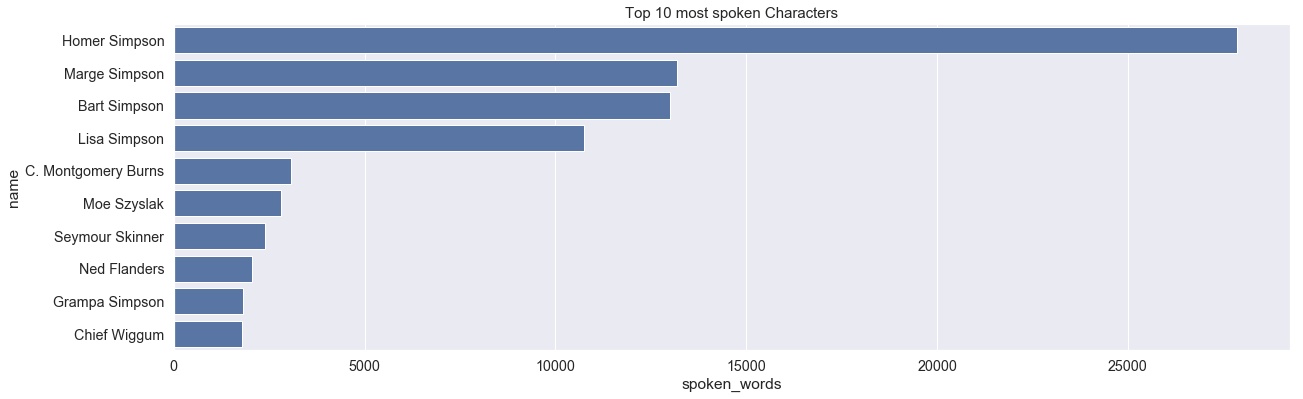

In [995]:
### Top spoken characters
topCharacters = df.groupby("name",as_index=False).count().sort_values("spoken_words", ascending=False).reset_index(drop=True)
topCharactersNames = topCharacters.head(20).name.tolist()
display(topCharacters.head(10))

sns.set(style="whitegrid")

sns.set(font_scale=1.3)  
sns.barplot(x='spoken_words', y='name', data=topCharacters.head(10), color="b")            
plt.title("Top 10 most spoken Characters", size=15)
fig=plt.gcf()
fig.set_size_inches(20,6)
plt.show()

<hr>

### Text processing
* Removes non-alphabetic characters
* Remove stop words
* Apply lemitization

In [997]:
### Removes non-alphabetic characters:

df.spoken_words = [re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words']]
df.spoken_words= [re.sub("[/']", '', str(row)).lower() for row in df.spoken_words]

In [1000]:
import functools
import operator
from nltk.corpus import stopwords

stopwords = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def processSentence(sentence):
    ww = sentence.split()
    #ww = nltk.word_tokenize(sentence)
    ww = [x for x in ww if x not in stopwords]
    ww = [x for x in ww if x !=""]
    ww = [lemmatizer.lemmatize(x) for x in ww]
    if len(ww)>2:
        return " ".join(ww)
    else:
        return np.nan

cleaned = [processSentence(x) for x in df.spoken_words.tolist()]

dfCleaned = df.copy()
dfCleaned.spoken_words = cleaned
dfCleaned = dfCleaned.dropna()
dfCleaned = dfCleaned[~dfCleaned.spoken_words.duplicated()]
dfCleaned.columns = ["Name", "Sentence"]

wordsDf = pd.DataFrame(cleaned, columns=["sentence"]).dropna().drop_duplicates()
print("Words count after processing: "+ str(len(wordsDf)))

Words count after processing: 97203


### Top most Common Words

,Word,Count
0,im,8916
1,oh,7167
2,well,6660
3,dont,6406
4,like,5963
5,get,5127
6,one,4854
7,youre,4738
8,know,4608
9,thats,4052


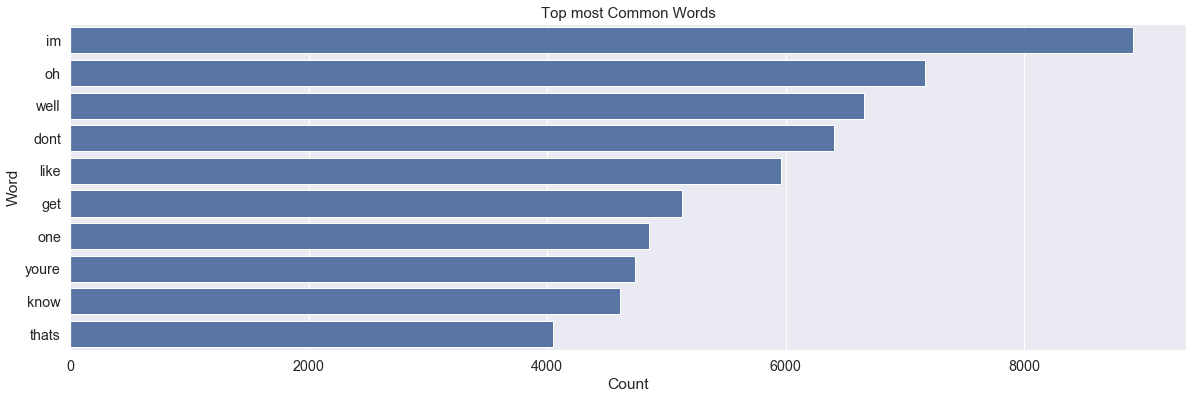

In [1001]:
words = [x.split() for x in wordsDf.sentence.tolist()]
words = functools.reduce(operator.iconcat, words, [])
wordCountsDF = pd.DataFrame(pd.Series(words).value_counts(), columns=["Count"])
wordCountsDF["Word"] = wordCountsDF.index
wordCountsDF = wordCountsDF[["Word", "Count"]].reset_index(drop=True)
display(wordCountsDF.head(10))

sns.set(style="whitegrid")

sns.set(font_scale=1.3)  
sns.barplot(x='Count', y='Word', data=wordCountsDF.head(10), color="b")            
plt.title("Top most Common Words", size=15)
fig=plt.gcf()
fig.set_size_inches(20,6)
plt.show()

### Generate word cloud

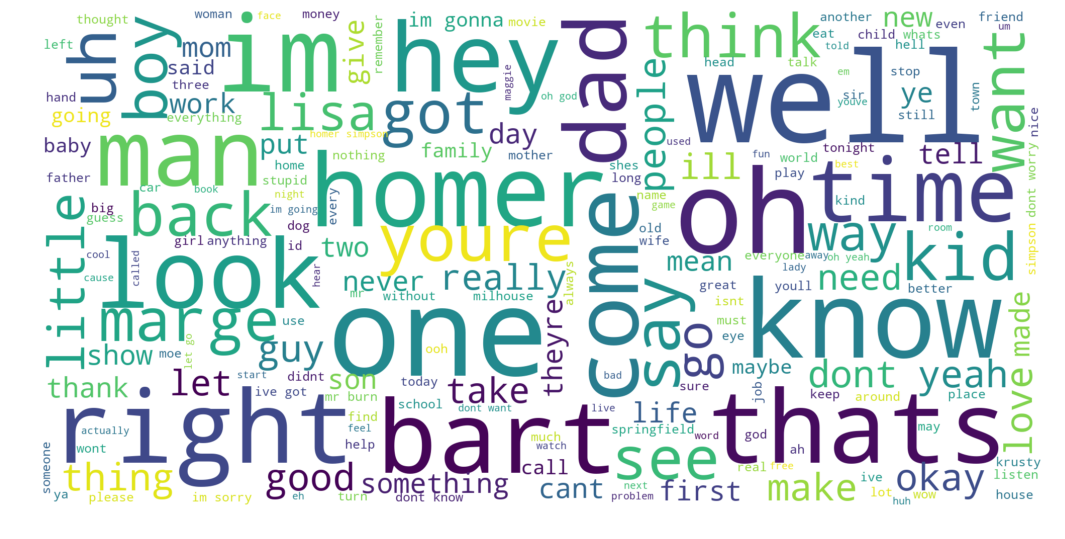

In [1288]:

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = list(set(STOPWORDS))


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=50, 
        scale=5,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(18, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()

show_wordcloud(" ".join(words))

### Dispersion_plot

Let`s look on this set of words ["homer", "simpson", "marge", "bart", "lisa"]

How ofter they how often they were used throughout the dialogue

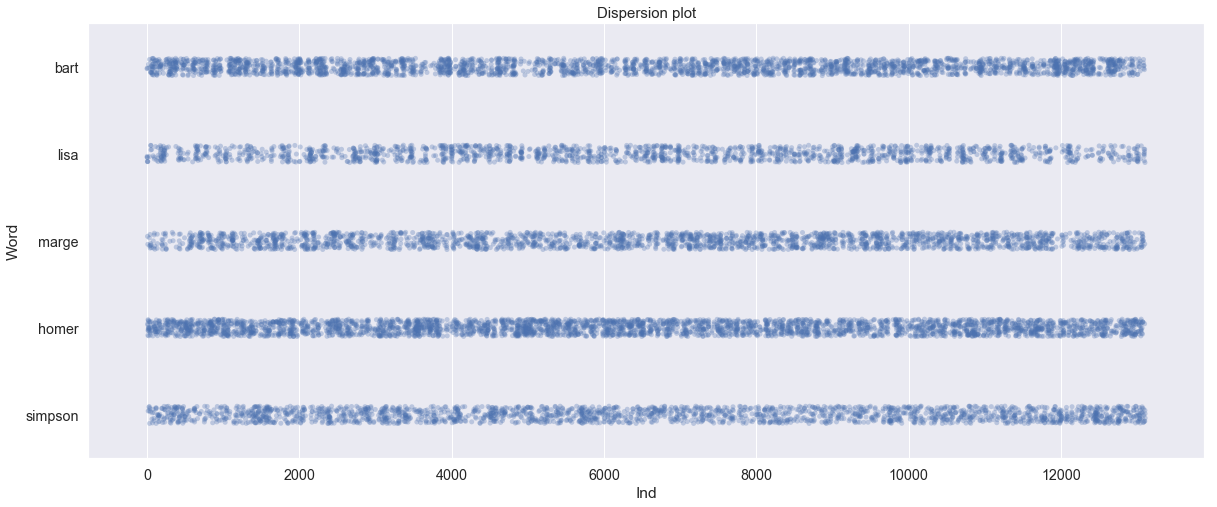

In [1051]:
tt= wordCountsDF.head(10).Word.tolist()
tt = ["homer", "simpson", "marge", "bart", "lisa"]

wordsTemp = [x for x in words if x in tt]
tempdf = pd.DataFrame(wordsTemp, columns=["Word"])
tempdf["Ind"] = tempdf.index

sns.set(style="whitegrid")

tt= wordCountsDF.Word.head(10)
wordsTemp = [x for x in words if x in tt]
sns.set(font_scale=1.3)  
sns.stripplot(x="Ind", y="Word", data=tempdf, color="b", alpha=0.3)            
plt.title("Dispersion plot", size=15)
fig=plt.gcf()
fig.set_size_inches(20,8)
plt.show()

In [691]:
### TfidfVectorizer

#txt1 = wordsDf.sentence.tolist()
#tf = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')
#txt_fitted = tf.fit(txt1)
#txt_transformed = txt_fitted.transform(txt1)

#idf = tf.idf_
#rr = dict(zip(txt_fitted.get_feature_names(), idf))

#token_weight = pd.DataFrame.from_dict(rr, orient='index').reset_index()
#token_weight.columns=('token','weight')
#token_weight = token_weight.sort_values(by='weight', ascending=False)
#token_weight2 = token_weight.head(20)

#sns.barplot(x='token', y='weight', data=token_weight2)            
#plt.title("Inverse Document Frequency(idf) per token")
#fig=plt.gcf()
#fig.set_size_inches(20, 6)
#plt.show()

#display(token_weight2.head())

In [1052]:
# get feature names
#feature_names = np.array(tf.get_feature_names())
#sorted_by_idf = np.argsort(tf.idf_)
#print("Features with lowest idf:\n{}".format(
#       feature_names[sorted_by_idf[:3]]))
#print("\nFeatures with highest idf:\n{}".format(
#       feature_names[sorted_by_idf[-3:]]))

### Top Most Important words for specified character

Here using TF-IDF 

Lets` apply on Bart Simpson

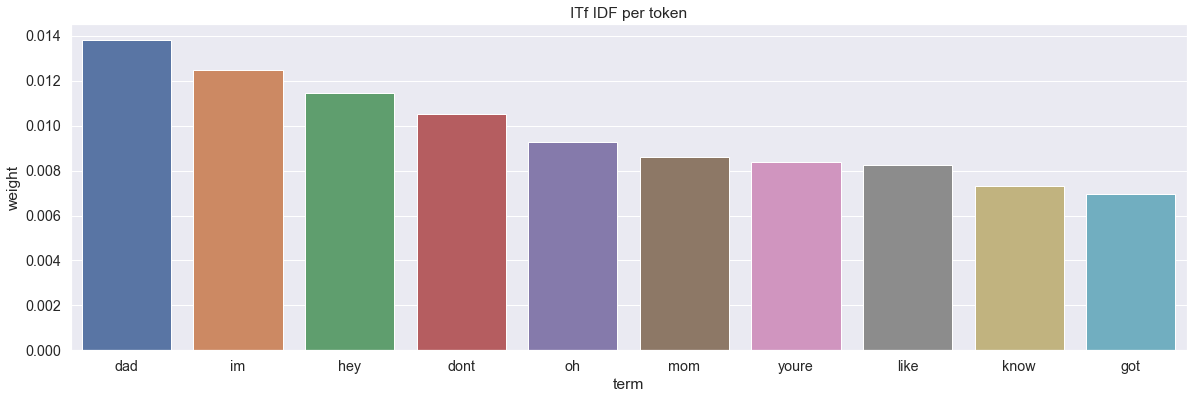

In [1148]:
# We will utilize CountVectorizer to convert a collection of text documents to a matrix of token counts. 
# TfidfTransformers handles transformation of a count matrix to a normalized TF or TF-IDF representation.

# We use 4 parameters in CountVectorizer method. First one is stop_words which removes words that occur a lot but do not contain necessary information. 
#‘None’ can be given if we don’t want to remove any word or we can give a list to choose which words are going to be swept ourselves. 
# In Scikit-learn, English stop word list is provided built-in. min_df parameter is a threshold value where we ignore terms that have a document frequency lower than min_df. 
# max_df is the contrast of min_df parameter. If the document frequency of a word is more than max_df, we ignore it. 
# ngram_range(x,y) is the last parameter which defines the boundary of n values for different n-grams. x is for the minimum n value, y represents the maximum n value for n-grams. 
# fit_transform returns transform version of sentences.

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

txt1 = [x for x in cleaned if str(x)!="nan"]
txt1 = dfCleaned[dfCleaned.Name=="Bart Simpson"].Sentence.tolist()

cvec = CountVectorizer(stop_words="english", analyzer='word', ngram_range=(1, 2), max_df=1.0, min_df=1)
sf = cvec.fit_transform(txt1)
    
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(sf)
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df = weights_df.sort_values("weight", ascending=False).reset_index(drop=False)

sns.barplot(x='term', y='weight', data=weights_df.head(10))            
plt.title("ITf IDF per token")
fig=plt.gcf()
fig.set_size_inches(20, 6)
plt.show()

We observe that the most important word for Bart is 'dad'.

<hr>

## Relationship among words

We have explored the most important words for a character. Now, we will explore the relationship between words.

Convert data to nGrams
* N-grams (sets of consecutive words)
* N=2

In [1150]:

from nltk.util import ngrams
import collections
import itertools

ngrams = list([nltk.ngrams(words, 2)])

# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*ngrams))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)
bigram_df = pd.DataFrame(bigram_counts.most_common(30), columns=['bigram', 'count'])

display(bigram_df.head(10))

,bigram,count
0,"(im, gonna)",823
1,"(dont, know)",741
2,"(im, sorry)",594
3,"(ive, got)",565
4,"(look, like)",562
5,"(dont, worry)",517
6,"(mr, burn)",475
7,"(homer, simpson)",430
8,"(dont, want)",411
9,"(let, go)",398


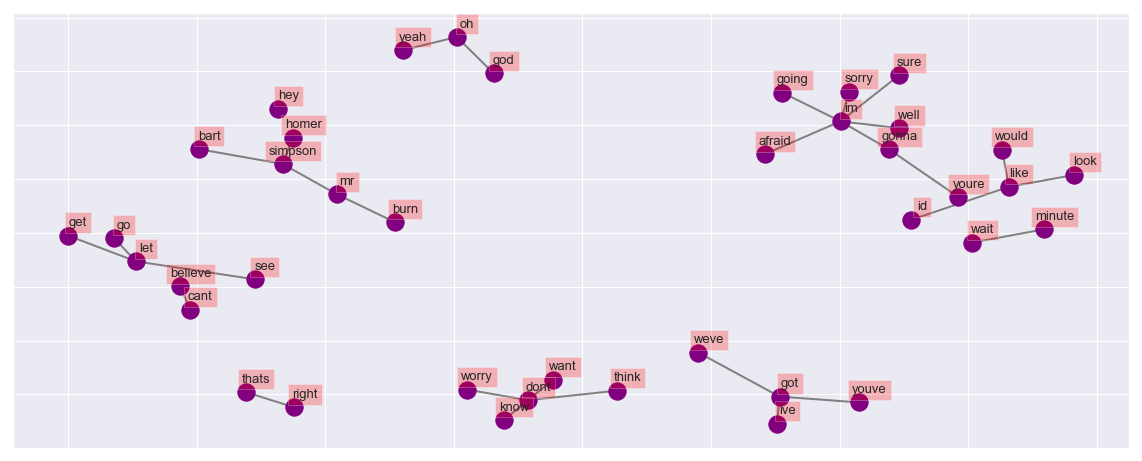

In [697]:
### Visualize Networks of Bigrams

import networkx as nx

def visulaizeBigrams(bigram_df, K):
    d = bigram_df.set_index('bigram').T.to_dict('records')

    # Create network plot 
    G = nx.Graph()

    # Create connections between nodes
    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v * 10))

    #G.add_node("china", weight=100)
    fig, ax = plt.subplots(figsize=(20, 8))
    
    # k : float (default=None)
    # Optimal distance between nodes. 
    # If None the distance is set to 1/sqrt(n) where n is the number of nodes. Increase this value to move nodes farther apart.
    pos = nx.spring_layout(G, k=K)

    # Plot networks
    nx.draw_networkx(G, pos,
                     font_size=13,
                     width=2,
                     edge_color='grey',
                     node_color='purple',
                     with_labels = False,
                     ax=ax)

    # Create offset labels
    for key, value in pos.items():
        x, y = value[0]+.02, value[1]+.045
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='red', alpha=0.25),
                horizontalalignment='center', fontsize=13)
    plt.grid(True)
    plt.show()
    
visulaizeBigrams(bigram_df=bigram_df,  K=5)

The above infographic shows the words which follow another word. E.g. 

For example, the word 'simpson' is preceded by words such as:
 * homer
 * bart
 * lisa
 * burn

Also very interesying we can see if look on word "im".

It is combined with words such:
* sorry
* afraid
* going

And it looks right. Since there are permanent phrases: "I'm sorry, I'm afraid ... "

Looks like it is making sense!

### Make network graph for specific word

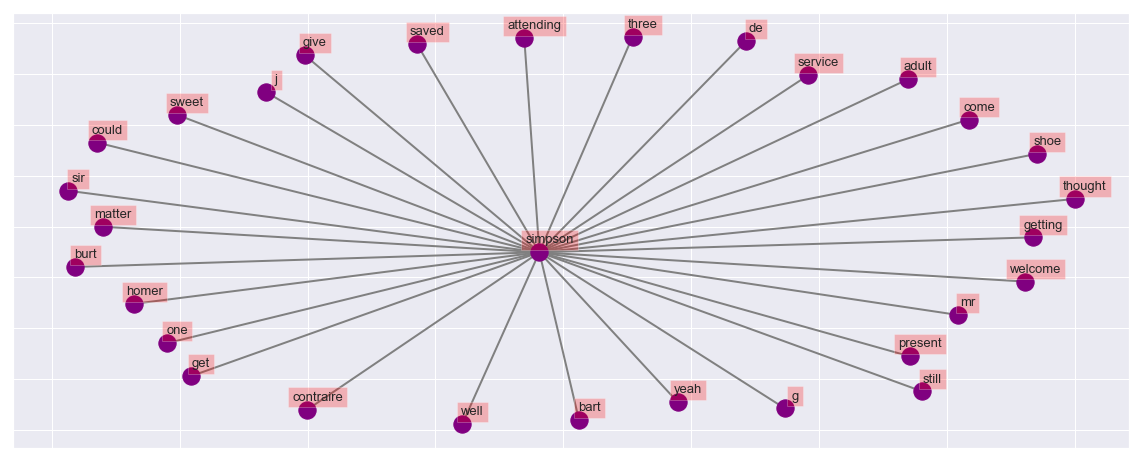

In [699]:
### Make graph only for specific word

wordGToGraph = "simpson"
bigram_df = pd.DataFrame(bigram_counts.most_common(30), columns=['bigram', 'count'])

### filter nframs list
bigram_counts_filter = []
for k in bigram_counts:
    #print(k)
    if wordGToGraph in k:
        bigram_counts_filter.append(k)
        
bigram_counts_filter = collections.Counter(bigram_counts_filter)
bigram_df_filter = pd.DataFrame(bigram_counts_filter.most_common(30), columns=['bigram', 'count'])
visulaizeBigrams(bigram_df=bigram_df_filter,  K=5)

<hr>

### Sentiment analysis

In [1155]:
from textblob import TextBlob

### Calculate sentiment for all data
dfCleaned["Sentiment"] = [TextBlob(x).sentiment.polarity for x in dfCleaned.Sentence]

In [1192]:
## select subset, as top n active characters
topCharactersNames = topCharacters.head(70).name.tolist()
dfCleanedTopCharacters = dfCleaned[dfCleaned.Name.isin(topCharactersNames)]

##### Top NOT so positive sentiments are:

In [1193]:
### top NOT so positive sentiments are
dfCleanedTopCharacters.sort_values("Sentiment").head().reset_index(drop=True)

,Name,Sentence,Sentiment
0,Moe Szyslak,thats worst name ever heard,-1.0
1,Comic Book Guy,worst movie ever send,-1.0
2,Marge Simpson,could terrible thing youve ever done life worst despicable,-1.0
3,Marge Simpson,wonder he going say anything horrible fish,-1.0
4,Homer Simpson,oh dr hibbert boring homer weve got get lump checked homer must discus test result homer weve got find donor blah blah blah blah blah blah,-1.0


##### Top positive sentiments are:

In [1194]:
### top positive sentiments are
dfCleanedTopCharacters.sort_values("Sentiment").tail().reset_index(drop=True)

,Name,Sentence,Sentiment
0,Marge Simpson,well maybe best,1.0
1,Lisa Simpson,maybe best way keep student cheating trust cheat,1.0
2,Lenny Leonard,say homer youre real good think could dump girlfriend doreen,1.0
3,Louie,whoa im impressed guy,1.0
4,Grampa Simpson,yep may best known abraham history,1.0


### Sentiment by character



In [1195]:
sentimateByName = dfCleanedTopCharacters[dfCleanedTopCharacters.Sentiment.abs()>=0.05].groupby("Name", as_index=False).mean()
sentimateByName = sentimateByName.sort_values("Sentiment", ascending=False).reset_index(drop=True)

### Display a few best and worst characters up to to sentiment score

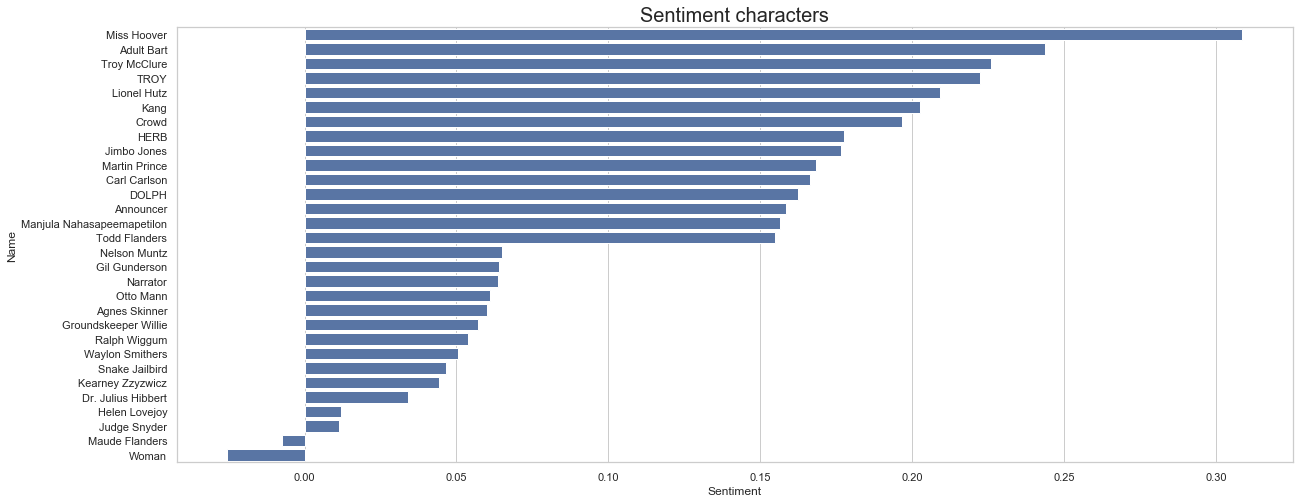

In [1287]:
sns.set(style="whitegrid")

tempSentiment = sentimateByName.head(15)
tempSentiment = tempSentiment.append(sentimateByName.tail(15)).reset_index(drop=True)

sns.barplot(x='Sentiment', y='Name', data=tempSentiment, color="b")            
plt.title("Sentiment characters", size=20)
fig=plt.gcf()
fig.set_size_inches(20,8)
plt.show()


Сan observe the following:

* Miss Hoover, has the most positive sentiment.
* Woman, is the most negative.

<hr>

### Rolling Sentiment

In [705]:
def rollingSentiment(data, character, window, k):
    if character!="":
        temp = data[data.Name==character].reset_index(drop=True)
    else:
        temp = data.copy()
    temp = temp[temp.Sentiment.abs()>=k].reset_index(drop=True)
    movingS = temp.rolling(window).mean().dropna()
    movingS["Time"] = movingS.index
    
    sns.set(style="whitegrid")
    sns.set(font_scale=1.3)  
    sns.lineplot(x="Time", y='Sentiment', data=movingS, color="b")            
    plt.title("Sentiment for " + character, size=20)
    fig=plt.gcf()
    fig.set_size_inches(20, 6)
    plt.show()
    return movingS


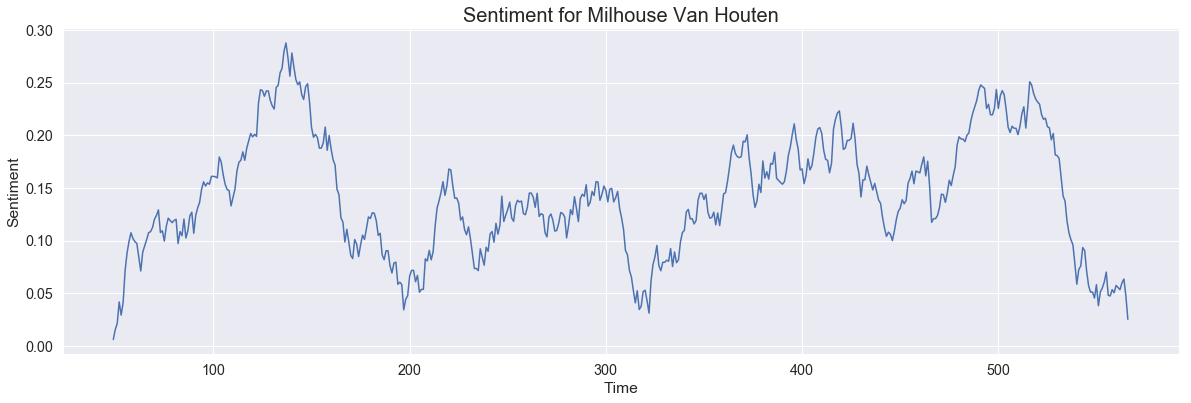

In [706]:
rolData = rollingSentiment(data=dfCleaned, character="Milhouse Van Houten", window=50, k=0.05)

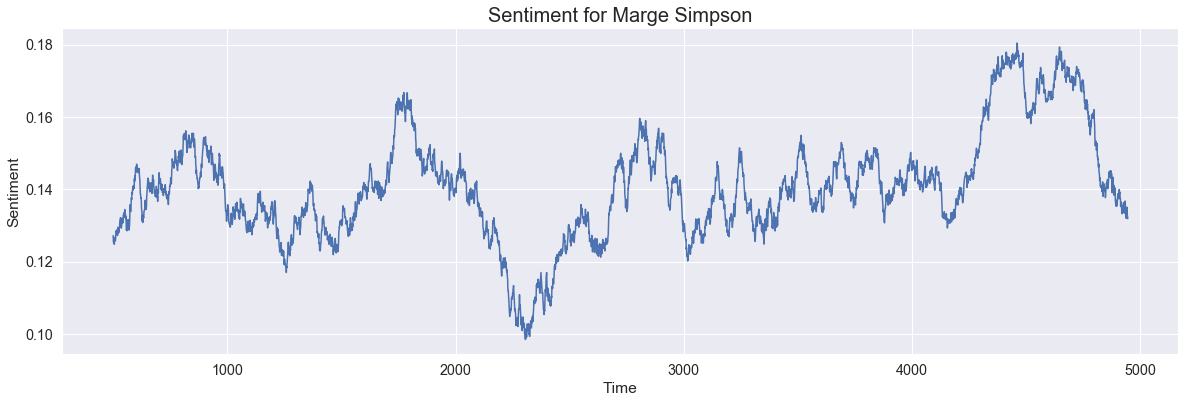

In [707]:
rolData = rollingSentiment(data=dfCleaned, character="Marge Simpson", window=500, k=0.05)

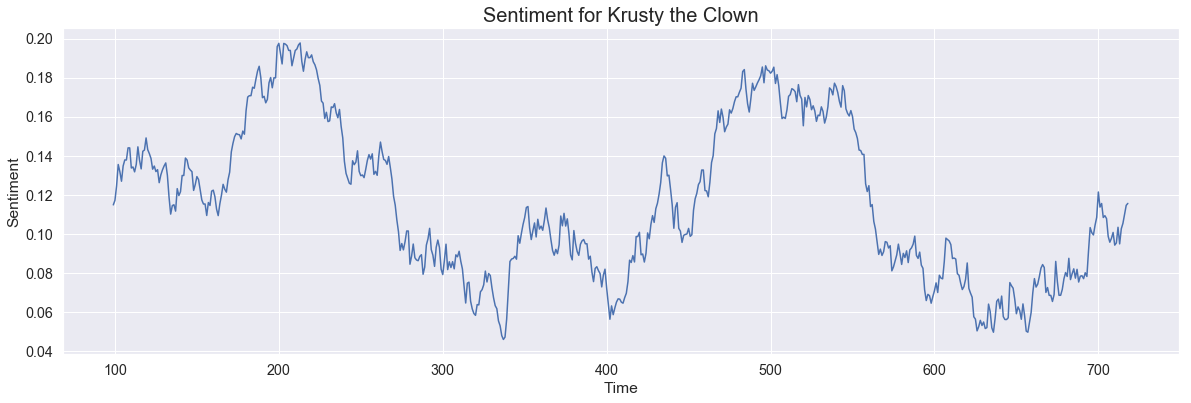

In [708]:
rolData = rollingSentiment(data=dfCleaned, character="Krusty the Clown", window=100, k=0.05)

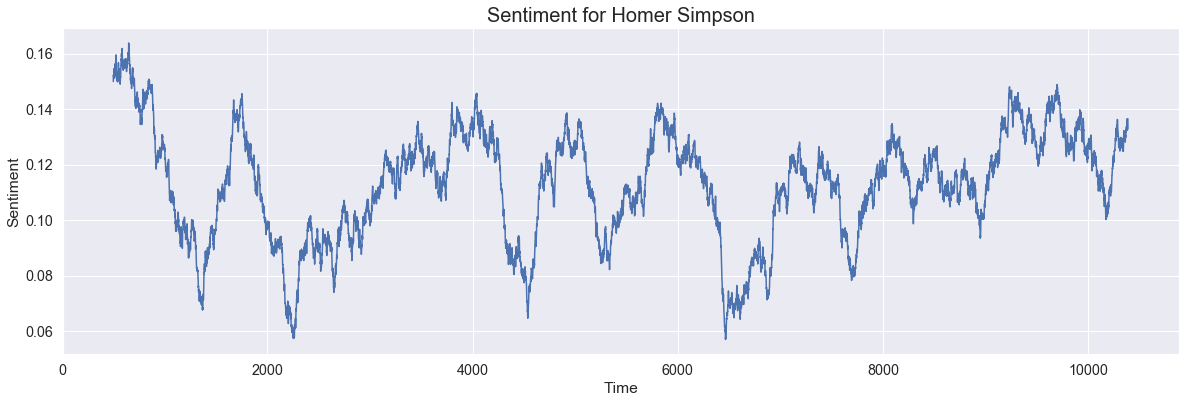

In [709]:
rolData = rollingSentiment(data=dfCleaned, character="Homer Simpson", window=500, k=0.05)

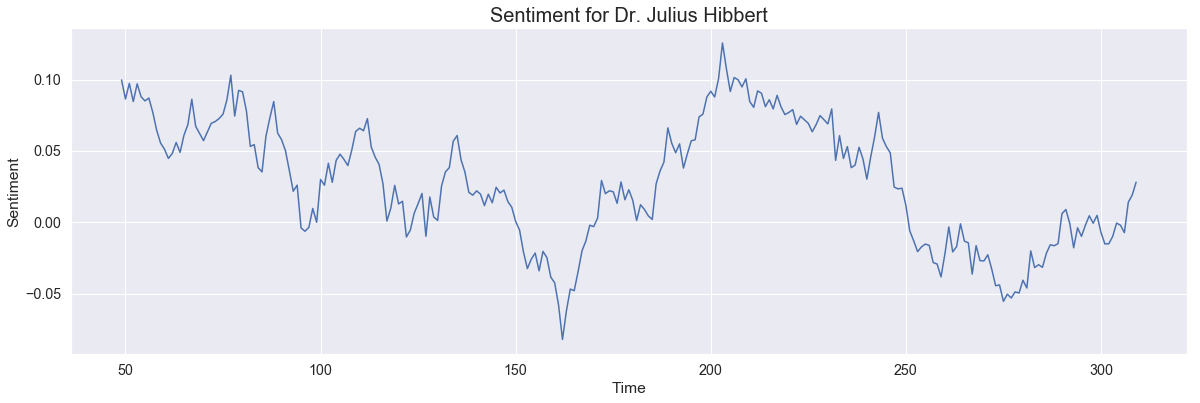

In [710]:
rolData = rollingSentiment(data=dfCleaned, character="Dr. Julius Hibbert", window=50, k=0.05)

### Training the model
#### Gensim Word2Vec Implementation:

In [737]:
#Training the model
#Gensim Word2Vec Implementation:

#The parameters:
#min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
#window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
#size = int - Dimensionality of the feature vectors. - (50, 300)
#sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
##alpha = float - The initial learning rate - (0.01, 0.05)
#min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
#negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
#workers = int - Use these many worker threads to train the model (=faster training with multicore machines)
#sg: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

In [712]:
import multiprocessing

from gensim.models import Word2Vec

In [1203]:

def processSentence2(sentence):
    ww = sentence.split()
    #ww = nltk.word_tokenize(sentence)
    ww = [x for x in ww if x not in stopwords]
    ww = [x for x in ww if x !=""]
    ww = [lemmatizer.lemmatize(x) for x in ww]
    if len(ww)>2:
        return " ".join(ww)
    else:
        return np.nan

cleaned2 = [processSentence2(x) for x in df.spoken_words.tolist()]
words22 = [x for x in cleaned2 if str(x)!="nan"]

In [1204]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
words33 = [x.split() for x in words22]

In [1223]:
w2v_model = Word2Vec(min_count=20,
                     window=5,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     sg = 1)

w2v_model.build_vocab(words33, progress_per=10000)

vocab_size = len(w2v_model.wv.vocab)

In [1224]:
st = datetime.now()

w2v_model.train(words33, total_examples=w2v_model.corpus_count, epochs=50, report_delay=1)

print('Time train: ' +  str(datetime.now()-st))

Time train: 0:00:32.286795


In [1225]:
w2v_model.init_sims(replace=True)

### Exploring the model

#### Most similar to:

Here, we will ask our model to find the word most similar to some of the most iconic characters of the Simpsons!

Let's see what we get for the Homer:

In [1226]:
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.6290415525436401),
 ('now', 0.611338198184967),
 ('simpson', 0.5987446308135986),
 ('bart', 0.5779693126678467),
 ('im', 0.5513642430305481),
 ('youre', 0.5343254208564758),
 ('oh', 0.5254324674606323),
 ('one', 0.5204833745956421),
 ('know', 0.5113734006881714),
 ('guy', 0.5111092329025269)]

Looks like it is making sense!

Let's see what we get for the Simpson:

In [1227]:
w2v_model.wv.most_similar(positive=["simpson"])

[('homer', 0.5987446308135986),
 ('now', 0.5356046557426453),
 ('bart', 0.5341618061065674),
 ('one', 0.5150291323661804),
 ('mr', 0.47792530059814453),
 ('youre', 0.4671880900859833),
 ('boy', 0.4588763117790222),
 ('man', 0.45424211025238037),
 ('well', 0.4451608657836914),
 ('know', 0.4443691372871399)]

Let's see what we get for the Marge:

In [1228]:
w2v_model.wv.most_similar(positive=["marge"])

[('homer', 0.6290415525436401),
 ('now', 0.5543875098228455),
 ('know', 0.5408905744552612),
 ('dont', 0.5377301573753357),
 ('im', 0.527373194694519),
 ('time', 0.5235589742660522),
 ('dad', 0.5153170824050903),
 ('bart', 0.5148717164993286),
 ('oh', 0.5142421126365662),
 ('thing', 0.511568009853363)]

Let's see what we get for the Bart:

In [1230]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.6345921158790588),
 ('boy', 0.5886171460151672),
 ('dad', 0.5838809013366699),
 ('homer', 0.5779693126678467),
 ('now', 0.5762186646461487),
 ('youre', 0.5551811456680298),
 ('mom', 0.5516786575317383),
 ('know', 0.544401228427887),
 ('im', 0.5351408123970032),
 ('well', 0.5348502397537231)]

### Similarities:

Here, we will see how similar are two words to each other :

In [1231]:
w2v_model.wv.similarity('maggie', 'baby')

0.34635302

### Analogy difference:

Which word is to woman as homer is to marge?

In [1232]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

[('now', 0.3524896204471588),
 ('simpson', 0.3517136871814728),
 ('say', 0.3359634280204773)]

### Character names relations

We can create a 2-dimensional PCA model of the word vectors using the scikit-learn PCA class.

Let`s take 20 most active characters.

In [974]:
### Viz characters
characters = topCharacters.head(20).name.tolist()
characters = [re.sub("[^A-Za-z.']+", ' ', str(row)).lower() for row in characters]
characters = [re.sub("[/']", '', str(row)) for row in characters]
characters = sum([x.split() for x in characters], [])
characters = np.unique([x for x in characters if len(x)>2 and "." not in x ])
characters = [x for x in characters if x in w2v_model.wv.vocab]

In [975]:
X = w2v_model[characters]

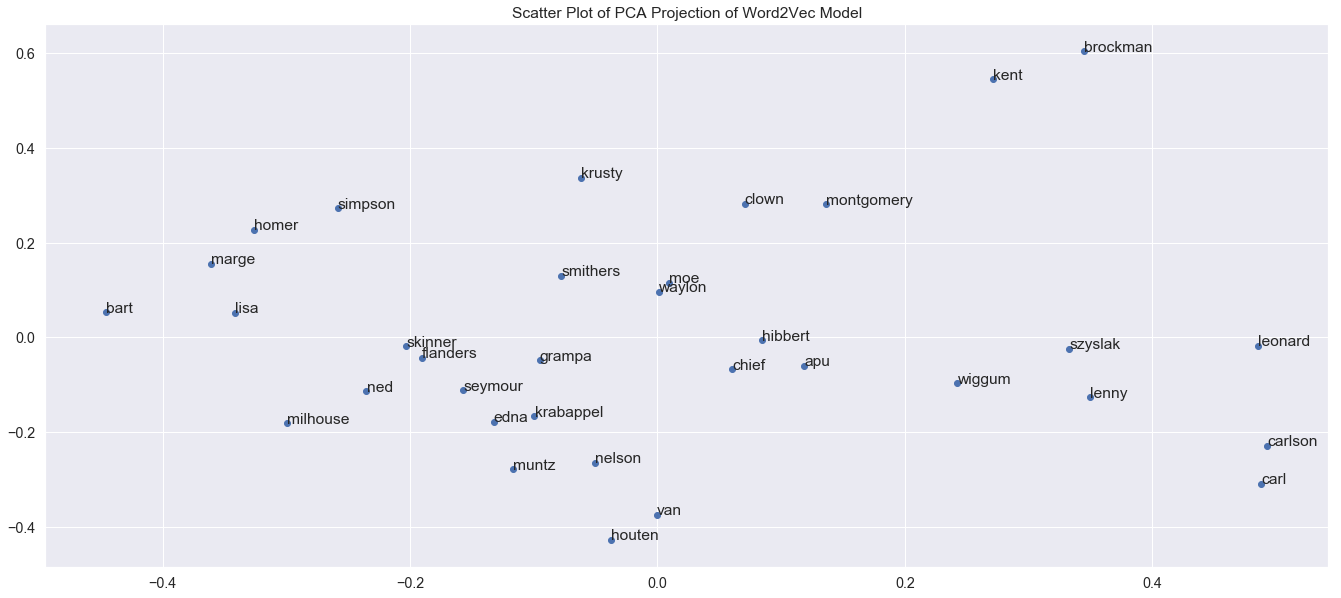

In [1285]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2)

result = pca.fit_transform(X)

# create a scatter plot of the projection
fig = plt.figure(figsize=(23,10))
ax = fig.add_subplot(111)
ax.scatter(result[:, 0], result[:, 1])
ax.set_title("Scatter Plot of PCA Projection of Word2Vec Model")
for i, word in enumerate(characters):
    ax.annotate(word, xy=(result[i, 0]+0.0001, result[i, 1]))
plt.show()

Interestingly, at the left side of chart we can see a group of names (Marge, Homer, Bart ...), and it is make sense, because all they are Simpsons

Also, we can see that Kent Brockman is far away from all points, and it is also make sense.

### 10 Most similar words vs. 8 Random words:

In [1283]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    
    sns.set_style("darkgrid")

    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE

    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(15, 7)
    
    # Basic plot
    sns.set(font_scale=1.3)  
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    plt.title('t-SNE visualization for {}'.format(word.title()), size=20)
    

Goal is to plot our рigh dimensions vectors into 2 dimensional graphs.
For that we are going to use t-SNE implementation from scikit-learn.

To make the visualizations more relevant, we will look at the relationships between a query word (in **red**), its most similar words in the model (in **blue**), and other words from the vocabulary (in **green**).

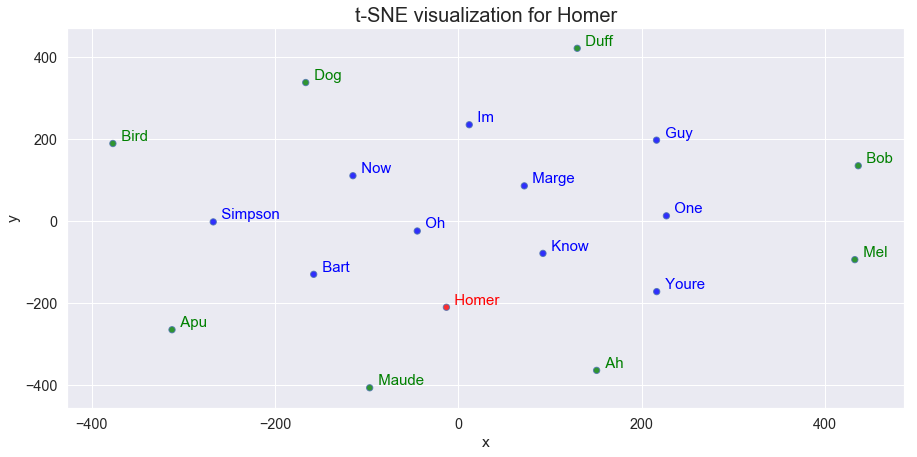

In [1284]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

Interestingly, the 10 most similar words to Homer ends up around him.

Look like it make sense!

<hr>